In [1]:
import json 
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt 
import seaborn as sns
import math

In [2]:
# 1. Import the CSV into your Python environment as a pandas dataframe.
shopping_basket_data = pd.read_csv('ml_engineering_coding_challenge.csv')
shopping_basket_data.head()

,user_id,fulfillment_method,state,cart_times,sales
0,788,Pickup,Washington,"{""created_at"":""2021-08-09 07:44:20.341""}",109.99
1,221,Pickup,Nevada,"{""created_at"":""2021-08-12 19:29:51.772""}",76.65
2,514,Pickup,Colorado,"{""checkout_time"":""2021-08-21 19:06:19.939"",""cr...",106.25
3,602,Pickup,Nevada,"{""checkout_time"":""2021-08-20 13:14:29.263"",""cr...",115.07
4,990,Pickup,Washington,"{""checkout_time"":""2021-08-18 11:52:37.087"",""cr...",127.62


In [3]:
# 2. Create a fulfillment_methods table that stores fulfillment_method values as integer
print(shopping_basket_data.fulfillment_method.value_counts())
fulfillment_methods = {
    'id': [i for i in range(len(shopping_basket_data.fulfillment_method.unique()))],
    'fulfillment_method': shopping_basket_data.fulfillment_method.unique()
}
fulfillment_methods = pd.DataFrame.from_dict(fulfillment_methods)
fulfillment_methods.head()

Pickup             838
Curbside Pickup    101
Delivery            61
Name: fulfillment_method, dtype: int64


,id,fulfillment_method
0,0,Pickup
1,1,Delivery
2,2,Curbside Pickup


In [4]:
# 3. Replace the fulfillment_method strings with their corresponding integer values from the table you created in #2.
shopping_basket_data.fulfillment_method.replace(dict(zip(fulfillment_methods.fulfillment_method, fulfillment_methods.id)), inplace=True)
shopping_basket_data.fulfillment_method.value_counts()

0    838
2    101
1     61
Name: fulfillment_method, dtype: int64

In [5]:
# 4. Extract the cart_times column into two separate columns labeled created_at and checkout_time.
shopping_basket_data['created_at'] = shopping_basket_data.cart_times.apply(lambda x: json.loads(x)['created_at'])
shopping_basket_data['checkout_time'] = shopping_basket_data.cart_times.apply(lambda x: json.loads(x)['checkout_time'] if 'checkout_time' in json.loads(x) else None)
shopping_basket_data.head()

,user_id,fulfillment_method,state,cart_times,sales,created_at,checkout_time
0,788,0,Washington,"{""created_at"":""2021-08-09 07:44:20.341""}",109.99,2021-08-09 07:44:20.341,None
1,221,0,Nevada,"{""created_at"":""2021-08-12 19:29:51.772""}",76.65,2021-08-12 19:29:51.772,None
2,514,0,Colorado,"{""checkout_time"":""2021-08-21 19:06:19.939"",""cr...",106.25,2021-08-21 19:03:27.711,2021-08-21 19:06:19.939
3,602,0,Nevada,"{""checkout_time"":""2021-08-20 13:14:29.263"",""cr...",115.07,2021-08-20 13:13:40.218,2021-08-20 13:14:29.263
4,990,0,Washington,"{""checkout_time"":""2021-08-18 11:52:37.087"",""cr...",127.62,2021-08-18 11:51:03.417,2021-08-18 11:52:37.087


In [6]:
# 5. Filter out carts with outlier sales (> 3 std devs).
print(len(shopping_basket_data))
shopping_basket_data = shopping_basket_data[(np.abs(stats.zscore(shopping_basket_data['sales'])) < 3)]
print(len(shopping_basket_data))

1000
996


In [7]:
# 6. Create a new column called minutes_to_checkout representing the amount of time between the created_at and checkout_time values for each cart.
shopping_basket_data['created_at'] = pd.to_datetime(shopping_basket_data.created_at)
shopping_basket_data['checkout_time'] = pd.to_datetime(shopping_basket_data.checkout_time)

def date_diff(created_at, checkout_time):
    if checkout_time is None:
        return None
    return (checkout_time - created_at).total_seconds() / 60

shopping_basket_data['minutes_to_checkout'] = shopping_basket_data.apply(lambda row: date_diff(row['created_at'], row['checkout_time']), axis = 1)
shopping_basket_data.head()

,user_id,fulfillment_method,state,cart_times,sales,created_at,checkout_time,minutes_to_checkout
0,788,0,Washington,"{""created_at"":""2021-08-09 07:44:20.341""}",109.99,2021-08-09 07:44:20.341,NaT,NaN
1,221,0,Nevada,"{""created_at"":""2021-08-12 19:29:51.772""}",76.65,2021-08-12 19:29:51.772,NaT,NaN
2,514,0,Colorado,"{""checkout_time"":""2021-08-21 19:06:19.939"",""cr...",106.25,2021-08-21 19:03:27.711,2021-08-21 19:06:19.939,2.870467
3,602,0,Nevada,"{""checkout_time"":""2021-08-20 13:14:29.263"",""cr...",115.07,2021-08-20 13:13:40.218,2021-08-20 13:14:29.263,0.817417
4,990,0,Washington,"{""checkout_time"":""2021-08-18 11:52:37.087"",""cr...",127.62,2021-08-18 11:51:03.417,2021-08-18 11:52:37.087,1.561167


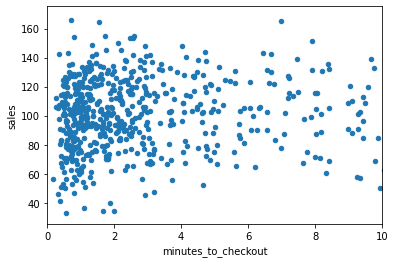

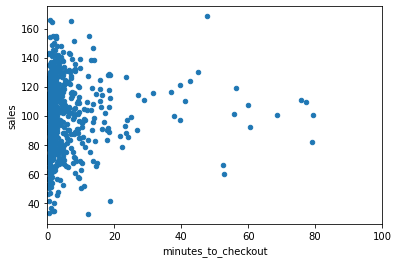

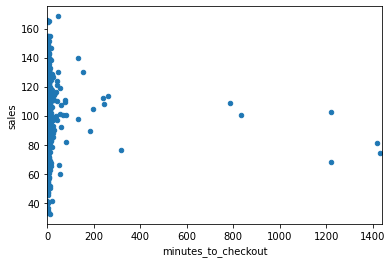

In [23]:
# 7. Analyze minutes_to_checkout vs. sales. Are there any patterns? What about between different states?
sbd = shopping_basket_data.loc[~np.isnan(shopping_basket_data.minutes_to_checkout)].copy()

sbd['log_minutes_to_checkout'] = sbd['minutes_to_checkout'].apply(lambda x: math.log(x))
sbd['log_sales'] = sbd['sales'].apply(lambda x: math.log(x))

for xlimit in (10, 100, 1440):
    sbd.plot(kind='scatter', x='minutes_to_checkout', y='sales', xlim=[0,xlimit])

### Analysis Part 1 (Ref plots above)
Minutes to checkout has some outliers, so we can take a look by limiting the x-axis in various ways. We see a possible slight negative correlation, but it's a little hard to tell from the scatter plots.

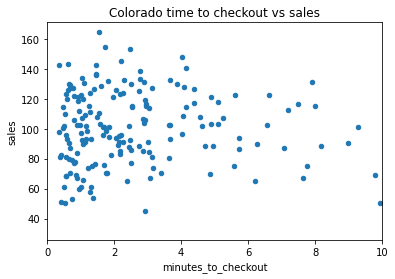

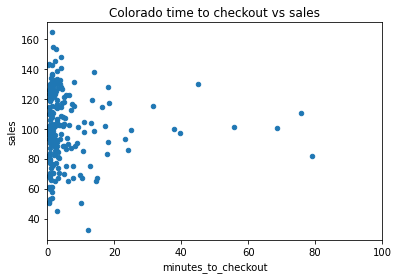

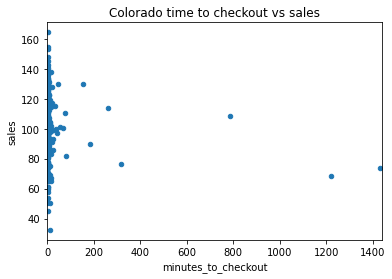

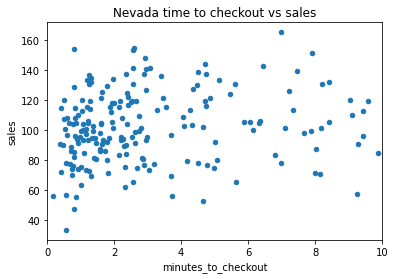

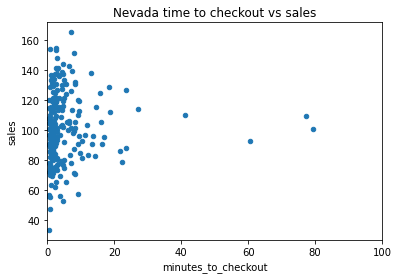

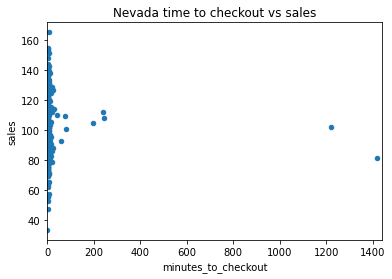

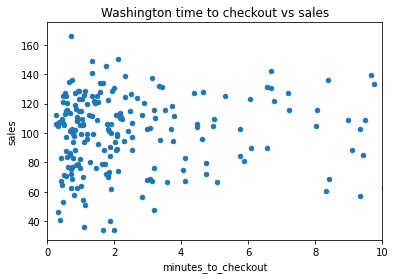

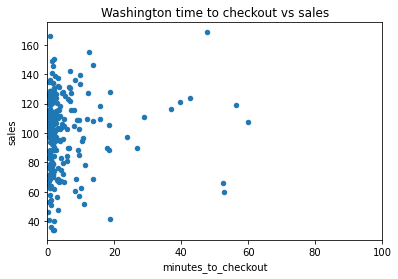

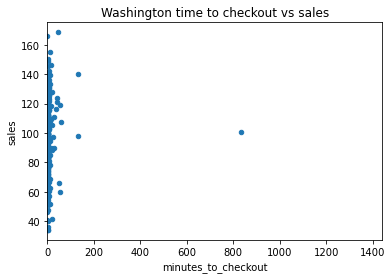

In [11]:
for state in sbd.state.unique():
    for xlimit in (10, 100, 1440):
        sbd.loc[sbd.state == state].plot(kind='scatter', x='minutes_to_checkout', y='sales', xlim=[0,xlimit], title='{} time to checkout vs sales'.format(state))

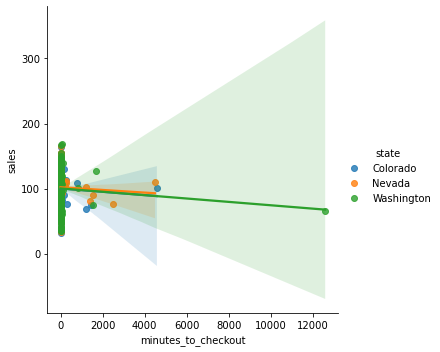

In [13]:
sns.lmplot(x="minutes_to_checkout", y="sales", hue="state", data=sbd)

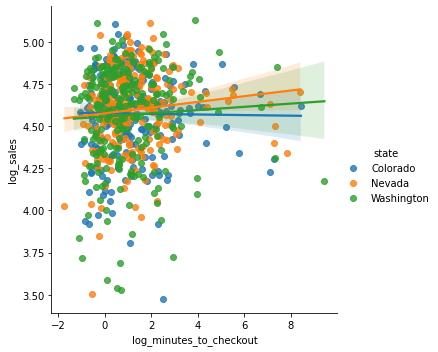

In [14]:
sns.lmplot(x="log_minutes_to_checkout", y="log_sales", hue="state", data=sbd)

### Analysis Part 2 (Ref plots above)
We can make a line of best fit to further see correlation. I also tried log transformations since the data seemed potentially skewed, especially the minutes_to_checkout. Again we see a slight negative correlation, meaning the longer a customer takes to checkout, it may lead to a slight loss in sales amount. There might be some slight differences based on which state the transaction is happening in. A takeaway we might glean here is that it's important to minimize time for customer to checkout in order to maximize revenue.

In [15]:
stats.pearsonr(sbd['sales'], sbd['minutes_to_checkout'])

(-0.05873295998768871, 0.12544146505237094)

In [16]:
for state in sbd.state.unique():
    sbd_state = sbd.loc[sbd.state==state]
    print("{}: ".format(state), stats.pearsonr(sbd_state['sales'], sbd_state['minutes_to_checkout']))

Colorado:  (-0.03623374871609782, 0.5972443587461457)
Nevada:  (-0.03353601246301948, 0.6136593728102026)
Washington:  (-0.08274223470309279, 0.20339206109216965)


In [17]:
stats.pearsonr(sbd['log_sales'], sbd['log_minutes_to_checkout'])

(0.04998777432884402, 0.19228209347953348)

In [18]:
for state in sbd.state.unique():
    sbd_state = sbd.loc[sbd.state==state]
    print("{}: ".format(state), stats.pearsonr(sbd_state['log_sales'], sbd_state['log_minutes_to_checkout']))

Colorado:  (-0.010508933717366137, 0.8782427964883169)
Nevada:  (0.106374346393369, 0.10838700094232658)
Washington:  (0.049048929723764206, 0.4513539869271033)


### Analysis Part 3 (Ref printouts above)
Lastly we can take a look at the correlation coefficients and associated p-values for both log-transformed and raw data. On the whole (for the raw data), the p-value is low, but a bit higher than we would typically consider statistically significant. Again, the coefficient here is negative with weak correlation. This just statistically confirms what we observed visually in the scatterplots above.

In [29]:
# 8. Export the sales dataframe as a CSV.
shopping_basket_data.to_csv('ml_engineering_output_nathanmoderwell.csv', index=False)

In [30]:
# 9. Export your fulfillment method aliases table as a CSV.
fulfillment_methods.to_csv('ml_engineering_fulfillment_aliases_nathanmoderwell.csv',index=False)

In [33]:
import os

os.system('jupyter nbconvert --to html data_eng.ipynb')

[NbConvertApp] Converting notebook data_eng.ipynb to html
[NbConvertApp] Writing 898600 bytes to data_eng.html


0